In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
#import statements
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream, duration
import glob
import os
from itertools import chain
import copy
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.layers import CuDNNLSTM,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from numpy import argmax
import gc
import keras.utils

In [21]:
def data_extractor(directory):
  """
    Summary:
    Function converts midi files to metadata and appends nested metadata lists into one large list
    composed of all the songs in the dataset.

    Parameters:
    directory: String representation of directroy where midi files are located

    Returns:
    list: sequential midi file metadata 
   """
  notes = []
  offsets = []
  for file in glob.glob(directory):
          mid = converter.parse(file)
          notes_to_parse = None
          prev_offset = 0
          
          try: 
              s2 = instrument.partitionByInstrument(mid)
              notes_to_parse = s2.parts[0].recurse() 
              
          except: 
              notes_to_parse = mid.flat.notes

          for i,element in enumerate(notes_to_parse):
              if isinstance(element, note.Note):
                  notes.append(str(element.pitch))
                  offset_dif = float(element.offset-prev_offset)
              
                  offsets.append(round(offset_dif,3))
                  prev_offset = element.offset
             
                 
              elif isinstance(element, chord.Chord):
                  notes.append('.'.join(str(n) for n in element.normalOrder))
                  offset_dif = float(element.offset-prev_offset)
                  
                  offsets.append(round(offset_dif,3))
                  prev_offset = element.offset

  return [notes,offsets]

In [22]:
data = data_extractor("/content/drive/MyDrive/midi_files/*.mid")
note_data = data[0]
offset_data = data[1]

unique_note_number = len(list(set(note_data)))
unique_notes = sorted(list(set(note_data)))
unique_offset_number = len(list(set(offset_data)))
unique_offsets = sorted(list(set(offset_data)))

Text(0, 0.5, 'Count')

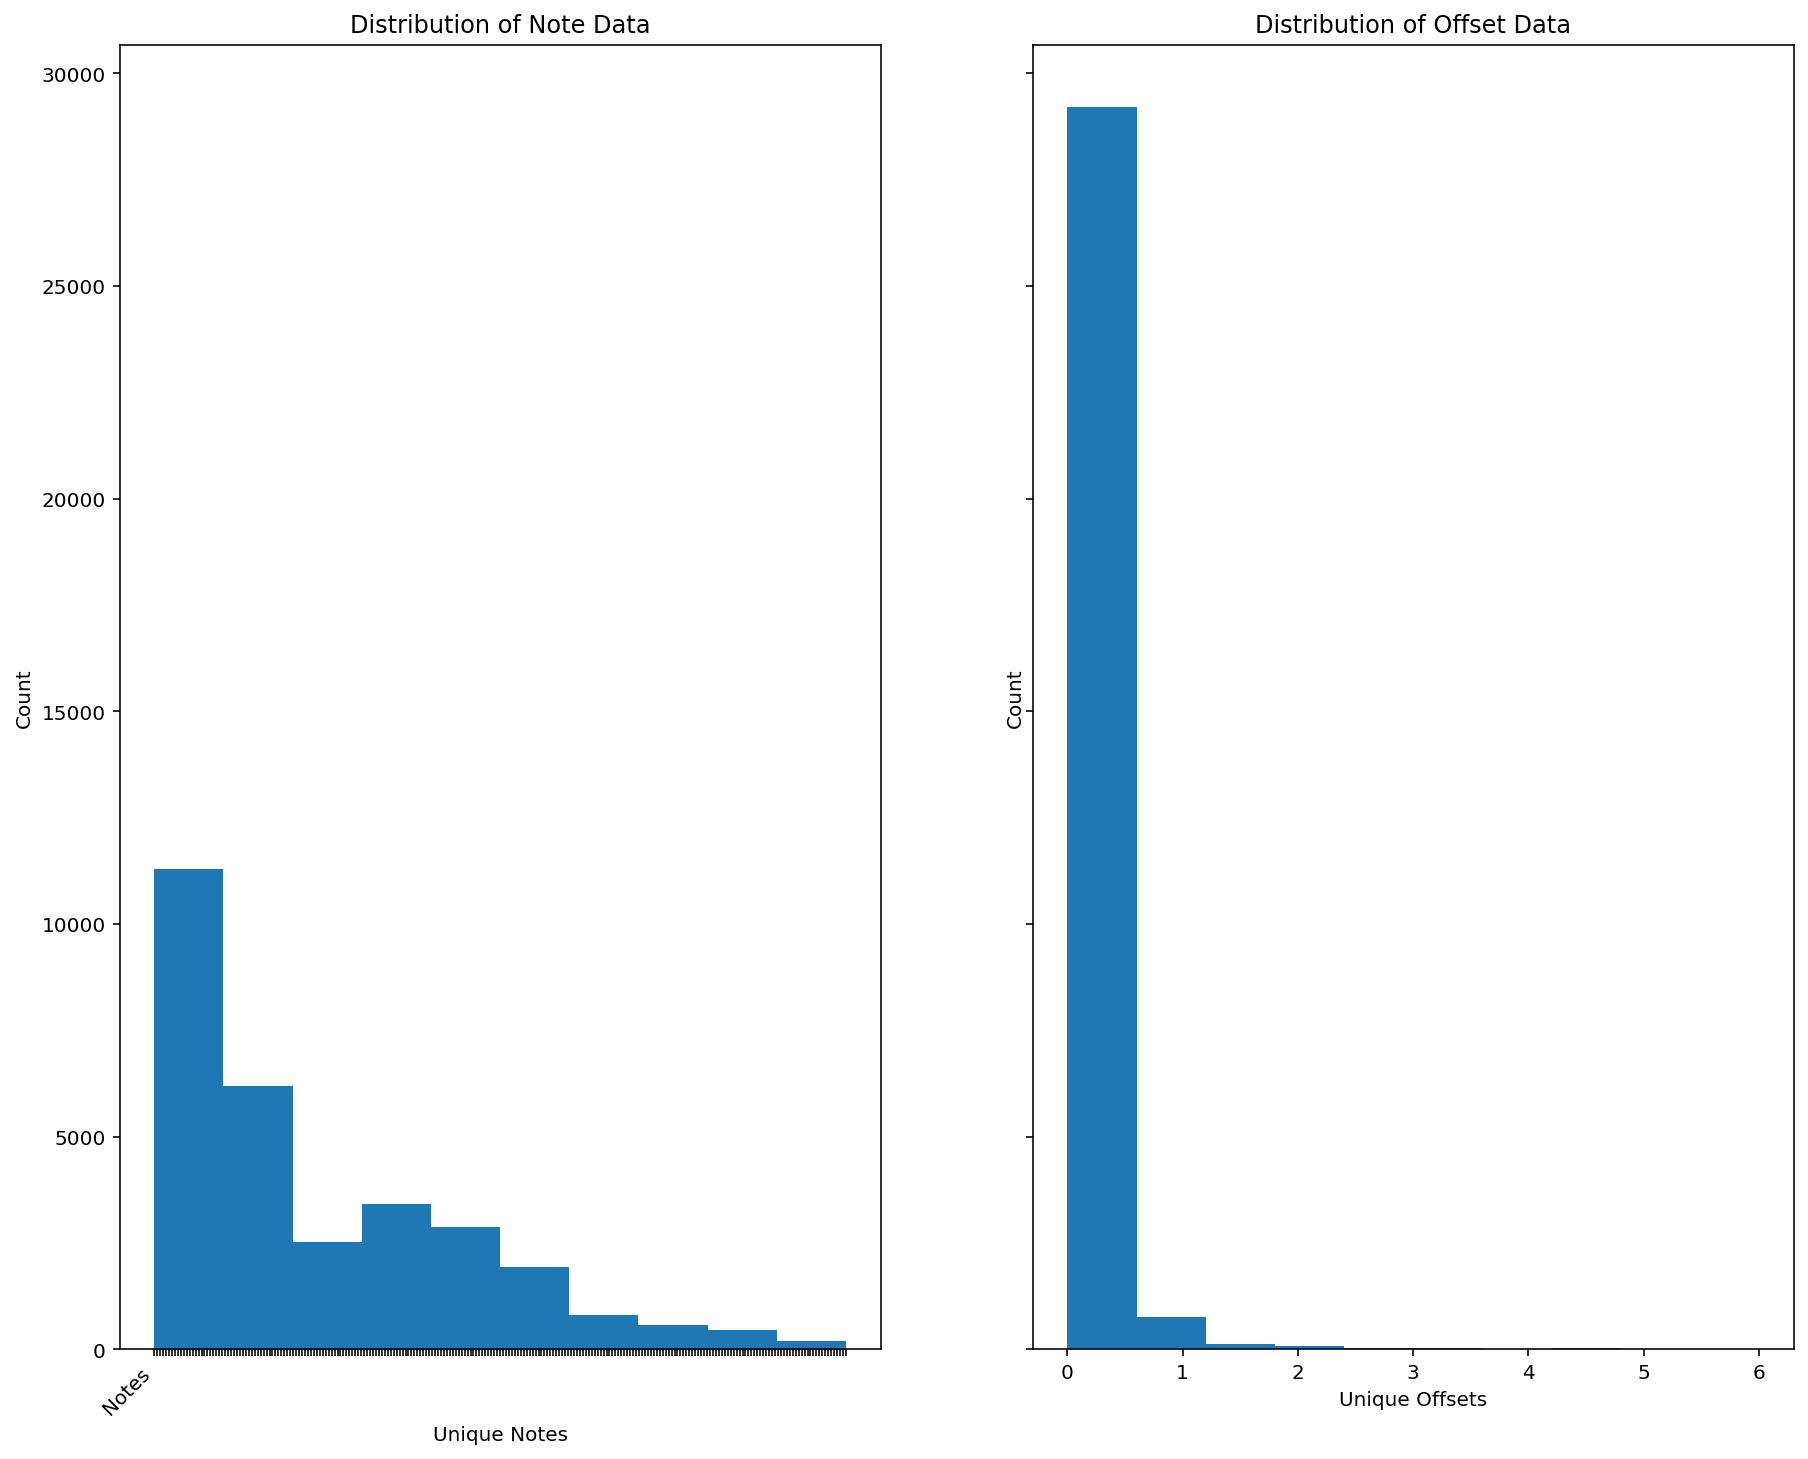

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,12))
ax1.hist(note_data);ax1.set_title('Distribution of Note Data');ax1.set_xlabel('Unique Notes');ax1.set_ylabel('Count')
ax1.set_xticklabels(labels = ["Notes"],rotation=45, ha='right')
ax2.hist(offset_data);ax2.set_title("Distribution of Offset Data");ax2.set_xlabel('Unique Offsets');ax2.set_ylabel('Count')

In [23]:
def one_hot_encode(vector, all_values):
  encoded_vectors = []
  int_to_index = dict((c, i) for i, c in enumerate(all_values))
  for i in vector:
    zero = [0]*(len(all_values)-1)
    zero.insert(int_to_index[i],1)
    encoded_vectors.append(zero)
  
  return encoded_vectors

In [24]:
def one_hot_decode(vector,all_values):
  decoded_vector = []
  index_to_int = dict((i, c) for i, c in enumerate(all_values))
  decoded_vector.append(index_to_int[argmax(vector)])
  return decoded_vector

In [48]:

segment_length = 64
def make_segments(data_array,unique_values, seq_length = segment_length,segment_type = 'note'):
  input_seq = []
  output_seq = []

  processed_data = one_hot_encode(data_array,unique_values)
  
  for i in range(0,len(processed_data) - seq_length,1):
    input_seq.append([processed_data[i:i+seq_length]])
    output_seq.append(processed_data[seq_length + i])

  del processed_data;gc.collect()
  
  input_seq = np.stack(arr[0] for arr in input_seq)
  output_seq = np.array(output_seq)

  return input_seq, output_seq

In [30]:
def test_data_pipeline():
  data = data_extractor("/content/drive/MyDrive/midi_short/*.mid")
  seg = make_segments(data_array = offset_data, unique_values = unique_offsets,segment_type = 'offset')
  
  check_list = []
  for i in seg[0][1]:
    check_list.append(one_hot_decode(i,unique_offsets)[0])

  if check_list == offset_data[1:len(seg[0][1])+1]:

    print('pipeline working')
  else:
    print('pipeline not working')
test_data_pipeline()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


pipeline working


In [49]:
note_model_data = make_segments(data_array = note_data, unique_values = unique_notes,segment_type = 'note')
offset_model_data = make_segments(data_array = offset_data, unique_values = unique_offsets,segment_type = 'offset')

In [50]:
X_train_note, X_test_note, y_train_note, y_test_note = train_test_split(note_model_data[0], note_model_data[1],test_size=0.2)
X_train_off, X_test_off, y_train_off, y_test_off = train_test_split(offset_model_data[0], offset_model_data[1],test_size=0.2)

In [51]:
del note_model_data
del offset_model_data
gc.collect()

44

In [53]:
def make_model(input_shape,output_shape):
  model = Sequential()
  model.add(CuDNNLSTM(256,input_shape=input_shape,return_sequences=False))
  model.add(Dropout(0.25))
  model.add(Dense(256))
  model.add(Dropout(0.25))
  model.add(Dense(output_shape,activation = 'softmax'))

  model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(learning_rate = .001),
      metrics=['accuracy']
  )
  return model

In [54]:
model_notes = make_model(input_shape = (segment_length,unique_note_number), output_shape = unique_note_number)
model_offsets = make_model(input_shape = (segment_length,unique_offset_number), output_shape = unique_offset_number)

In [55]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

In [56]:
history_note = model_notes.fit(X_train_note,y_train_note,epochs=150, validation_split = 0.2, callbacks = my_callbacks)

Epoch 1/150
604/604 [==============================] - 11s 9ms/step - loss: 4.2154 - accuracy: 0.0970 - val_loss: 3.7803 - val_accuracy: 0.1342
Epoch 2/150
604/604 [==============================] - 5s 8ms/step - loss: 3.5885 - accuracy: 0.1597 - val_loss: 3.4913 - val_accuracy: 0.1565
Epoch 3/150
604/604 [==============================] - 5s 8ms/step - loss: 3.3398 - accuracy: 0.1845 - val_loss: 3.3016 - val_accuracy: 0.1903
Epoch 4/150
604/604 [==============================] - 5s 8ms/step - loss: 3.1332 - accuracy: 0.2152 - val_loss: 3.1276 - val_accuracy: 0.2282
Epoch 5/150
604/604 [==============================] - 5s 8ms/step - loss: 2.9232 - accuracy: 0.2637 - val_loss: 2.9913 - val_accuracy: 0.2625
Epoch 6/150
604/604 [==============================] - 5s 8ms/step - loss: 2.7166 - accuracy: 0.3049 - val_loss: 2.8442 - val_accuracy: 0.2934
Epoch 7/150
604/604 [==============================] - 5s 8ms/step - loss: 2.5082 - accuracy: 0.3547 - val_loss: 2.7676 - val_accuracy: 0.326

In [57]:
history_offset = model_offsets.fit(X_train_off,y_train_off,epochs=150, validation_split = 0.2,callbacks = my_callbacks)

Epoch 1/150
604/604 [==============================] - 5s 7ms/step - loss: 1.1043 - accuracy: 0.6028 - val_loss: 0.9897 - val_accuracy: 0.6414
Epoch 2/150
604/604 [==============================] - 4s 7ms/step - loss: 0.9306 - accuracy: 0.6606 - val_loss: 0.8680 - val_accuracy: 0.6772
Epoch 3/150
604/604 [==============================] - 4s 7ms/step - loss: 0.8230 - accuracy: 0.7057 - val_loss: 0.7551 - val_accuracy: 0.7246
Epoch 4/150
604/604 [==============================] - 4s 7ms/step - loss: 0.7488 - accuracy: 0.7299 - val_loss: 0.7213 - val_accuracy: 0.7369
Epoch 5/150
604/604 [==============================] - 4s 7ms/step - loss: 0.7092 - accuracy: 0.7458 - val_loss: 0.6779 - val_accuracy: 0.7567
Epoch 6/150
604/604 [==============================] - 4s 7ms/step - loss: 0.6734 - accuracy: 0.7570 - val_loss: 0.6546 - val_accuracy: 0.7685
Epoch 7/150
604/604 [==============================] - 4s 6ms/step - loss: 0.6436 - accuracy: 0.7727 - val_loss: 0.6201 - val_accuracy: 0.7841

Text(0, 0.5, 'Loss')

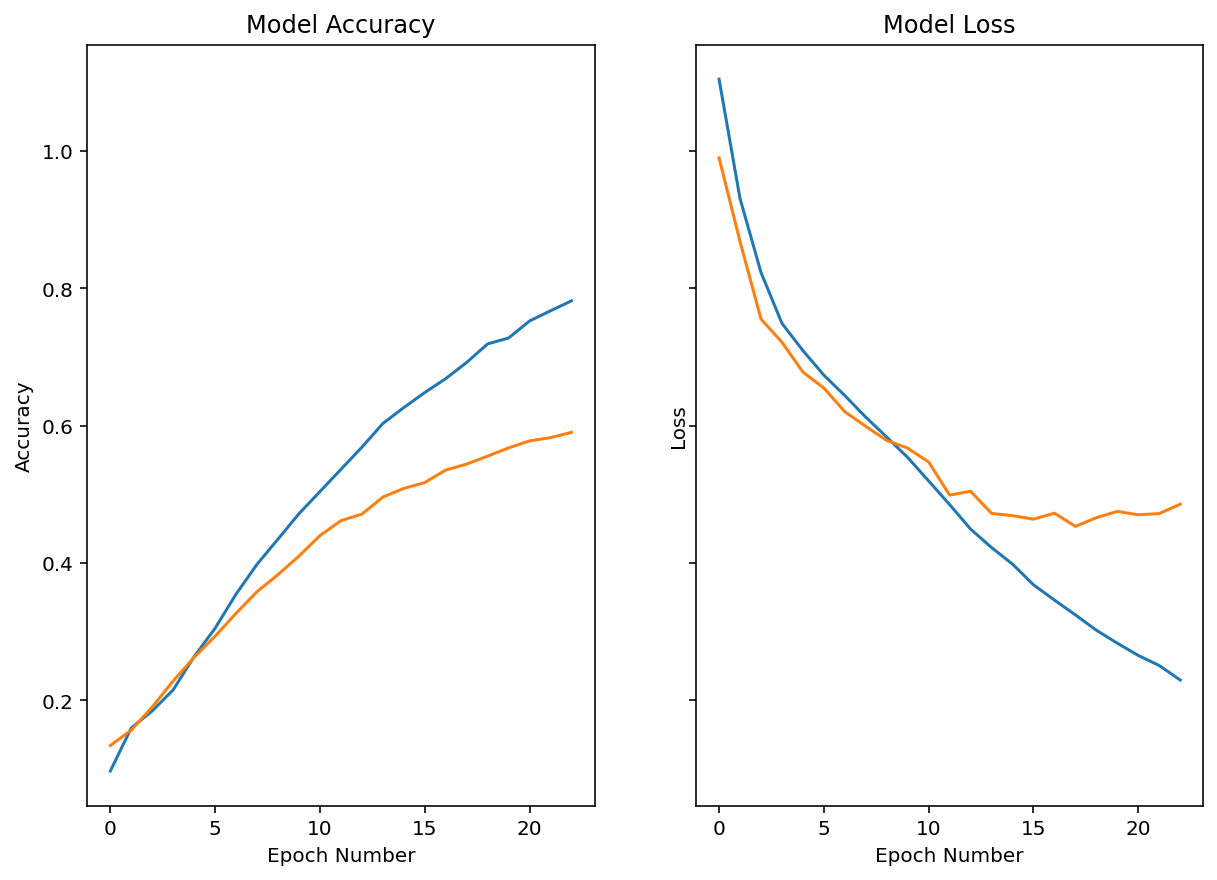

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,7))
ax1.plot(history_note.history['accuracy']);ax1.plot(history_note.history['val_accuracy'])
ax1.set_title('Model Accuracy');ax1.set_xlabel('Epoch Number');ax1.set_ylabel('Accuracy')
ax2.plot(history_offset.history['loss']);ax2.plot(history_offset.history['val_loss']);
ax2.set_title("Model Loss");ax2.set_xlabel('Epoch Number');ax2.set_ylabel('Loss')

In [63]:
def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  
    preds = preds / np.sum(preds)                
    probas = np.random.multinomial(1, preds, 1)  
    return np.argmax(probas)                     

In [64]:
def music_maker(seed_vec,model_type,number_unique,unique,num_notes = 100):
  music = []
  diversity = 0.7
  arr = np.zeros((len(seed_vec)+num_notes,number_unique))
  for c,i in enumerate(seed_vec):
    arr[c] = i

  for i in range(0,num_notes,1):
    d_arr = np.zeros(number_unique)
    pred = model_type.predict(np.reshape(arr[i:len(arr)-num_notes+i], (1, len(arr[i:len(arr)-num_notes+i]),number_unique)),verbose = 0)[0]
    diverse = sample(pred, diversity)
    d_arr[diverse] = 1
    music.append(one_hot_decode(d_arr,all_values = unique)[0])

    arr[len(seed_vec)+i] = d_arr
  
  return music

In [69]:
import random
randnum = random.randrange(0,len(X_test_note))
print("The current seed index is " + str(randnum))
test_note = X_test_note[randnum]
test_offset = X_test_off[randnum]
generated_music_note = music_maker(test_note, model_notes, unique_note_number,unique_notes)
generated_music_offset = music_maker(test_offset,model_offsets,unique_offset_number,unique_offsets)

The current seed index is 2725


In [70]:
seed_notes = []
seed_offsets = []
for n in test_note:
  seed_notes.append(one_hot_decode(n ,unique_notes)[0]) 
for o in test_offset:
  seed_offsets.append(one_hot_decode(o ,unique_offsets)[0]) 

In [71]:
def to_midi(notes,offsets):
  """
  Summary:
  Takes midi metadata and converts it to a Music21 stream. The stream can then easily be converted into a midi file.

  Parameters:
  metadata: midi metadata (notes,chords,offsets)

  Returns:
  list: Music21 stream object
  """
  offset = offsets[0]
  s = stream.Stream()
  for i,ele in enumerate(notes):
    if ele[0].isalpha():
      n = note.Note(ele)
      s.insert(offset,n)
      offset += offsets[i]
    else:
      chords = list(map(int,ele.split('.')))
      c = chord.Chord(chords)
      s.insert(offset,c)
      offset += offsets[i]
  return s

In [72]:
to_midi(generated_music_note,generated_music_offset).write('midi', "generated_classical.mid")
to_midi(seed_notes,seed_offsets).write('midi', "seed_classical.mid")

'seed_classical.mid'